# House price: feature select, stacking, blending (top 3%)
(Hoang Pham)

* [**1. Getting familiar with data**](#1)
    * [**1.1 Missing values**](#1.1)
    * [**1.2 Numeric features**](#1.2)
    * [**1.3 Categorical features**](#1.3)
    * [**1.4 Target column distribution**](#1.4)
* [**2. Feature engineering**](#2)
    * [**2.1 Binning continuous features**](#2.1)
    * [**2.2 Construct new useful features**](#2.2)
    * [**2.3 Feature selection**](#2.3)
        * [**2.3.1 Select categorical features**](#2.3.1)
        * [**2.3.2 Mismatched value between train & test set in categorical features**](#2.3.2)
        * [**2.3.3 Select contunious features**](#2.3.3)
    * [**2.4 Features transformation**](#2.4)
        * [**2.4.1 Highly skewed numeric features**](#2.4.1)
        * [**2.4.2 One-hot encoding categorical features**](#2.4.2)
* [**3. Modeling**](#3)
    * [**3.1 Base models**](#3.1)
    * [**3.2 Stacking model**](#3.2)
    * [**3.3 Blending model**](#3.3)
* [**4 Submision**](#4)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline  

from scipy import stats
from sklearn import preprocessing
from sklearn import feature_selection
import warnings
warnings.filterwarnings('ignore')
SEED = 42

<a name='1'></a>
# 1. Getting familiar with data
- Training set has 1460 rows, testing set has 1459 rows
- There are 81 features in training set and 80 features in testing set
- One extra feature in training set is "SalePrice" which is the target feature
- "df_all" the is concatenated dataframe between training and testing data for more convenience preprocessing. And we also should be careful about the "data leak" problem

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:1459], all_data.loc[1460:]

df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
y_train = df_train.SalePrice
id_val = df_train.Id
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
df_all = concat_df(df_train, df_test).drop(['SalePrice', 'Id'], axis=1)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print(f'Number of Training Examples = {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}\n')
print(f'Training X Shape = {df_train.shape}')
print(f'Training y Shape = {df_train["SalePrice"].shape[0]}\n')
print(f'Test X Shape = {df_test.shape}')
print(f'Test y Shape = {df_test.shape[0]}\n')
print(df_train.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 81)
Training y Shape = 1460

Test X Shape = (1459, 80)
Test y Shape = 1459

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<a name='1.1'></a>
## 1.1 Missing values

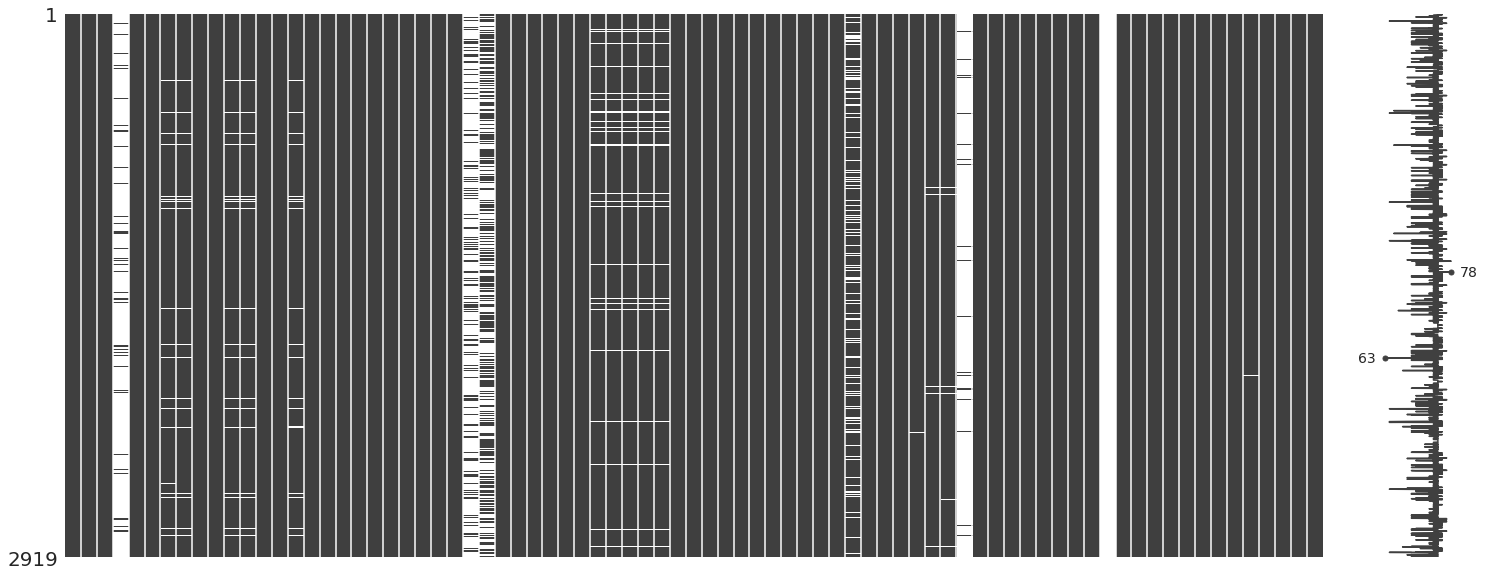

In [4]:
# Visualize the general missing values of data
msno.matrix(df_all)
plt.show()

In [5]:
for df in dfs:
    print(f'Only features contained missing value in {df.name}')
    temp = df.isnull().sum()
    print(temp.loc[temp!=0], '\n')

Only features contained missing value in Training Set
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64 

Only features contained missing value in Test Set
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76

- For features having missing value smaller than 100 -> I'll fill numeric features with the corresponding median & categorical features with the corresponding most frequent values
- For features having missing value larger than 1000 -> Removing these features might be a good choice
- For other features having missing value -> I'll fill them with "Null" value (b.c all the other features are object features)

In [6]:
null_features = df_all.isnull().sum()

# For features having smaller than 100 missing values
null_100 = df_all.columns[list((null_features < 100) & (null_features != 0))]
num = df_all[null_100].select_dtypes(include=np.number).columns
non_num = df_all[null_100].select_dtypes(include='object').columns
# Numerous features
df_all[num] = df_all[num].apply(lambda x: x.fillna(x.median()))
# Object features
df_all[non_num] = df_all[non_num].apply(lambda x: x.fillna(x.value_counts().index[0]))

# For features having larger than 1000 missing values
null_1000 = df_all.columns[list(null_features > 1000)]
df_all.drop(null_1000, axis=1, inplace=True)
df_all.drop(['GarageYrBlt', 'LotFrontage'], axis=1, inplace=True)

In [7]:
# For other features having missing values
# GarageCond
df_all['GarageCond'] = df_all['GarageCond'].fillna('Null')
# GarageFinish
df_all['GarageFinish'] = df_all['GarageFinish'].fillna('Null')
# GarageQual
df_all['GarageQual'] = df_all['GarageQual'].fillna('Null')
# GarageType
df_all['GarageType'] = df_all['GarageType'].fillna('Null')

In [8]:

# Update training & testing data
df_train, df_test = divide_df(df_all)
df_train = pd.concat([df_train, y_train], axis=1)

# Checking existing missing value or not
print('If the result is zero means not exist any missing values in dataset')
print(df_all.isnull().any().sum())

If the result is zero means not exist any missing values in dataset
0


<a name='1.2'></a>
## 1.2 Numeric features
- There are totally 34 numeric features in the dataset
- We'll visualize the features having the high level of correlation with target feature (SalePrice)

In [9]:
# Seeing the correlation between features and target
df_train_corr = df_train.corr()['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])
df_train_corr.head(10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Visualize the 16 features which has the highest correlation with the target

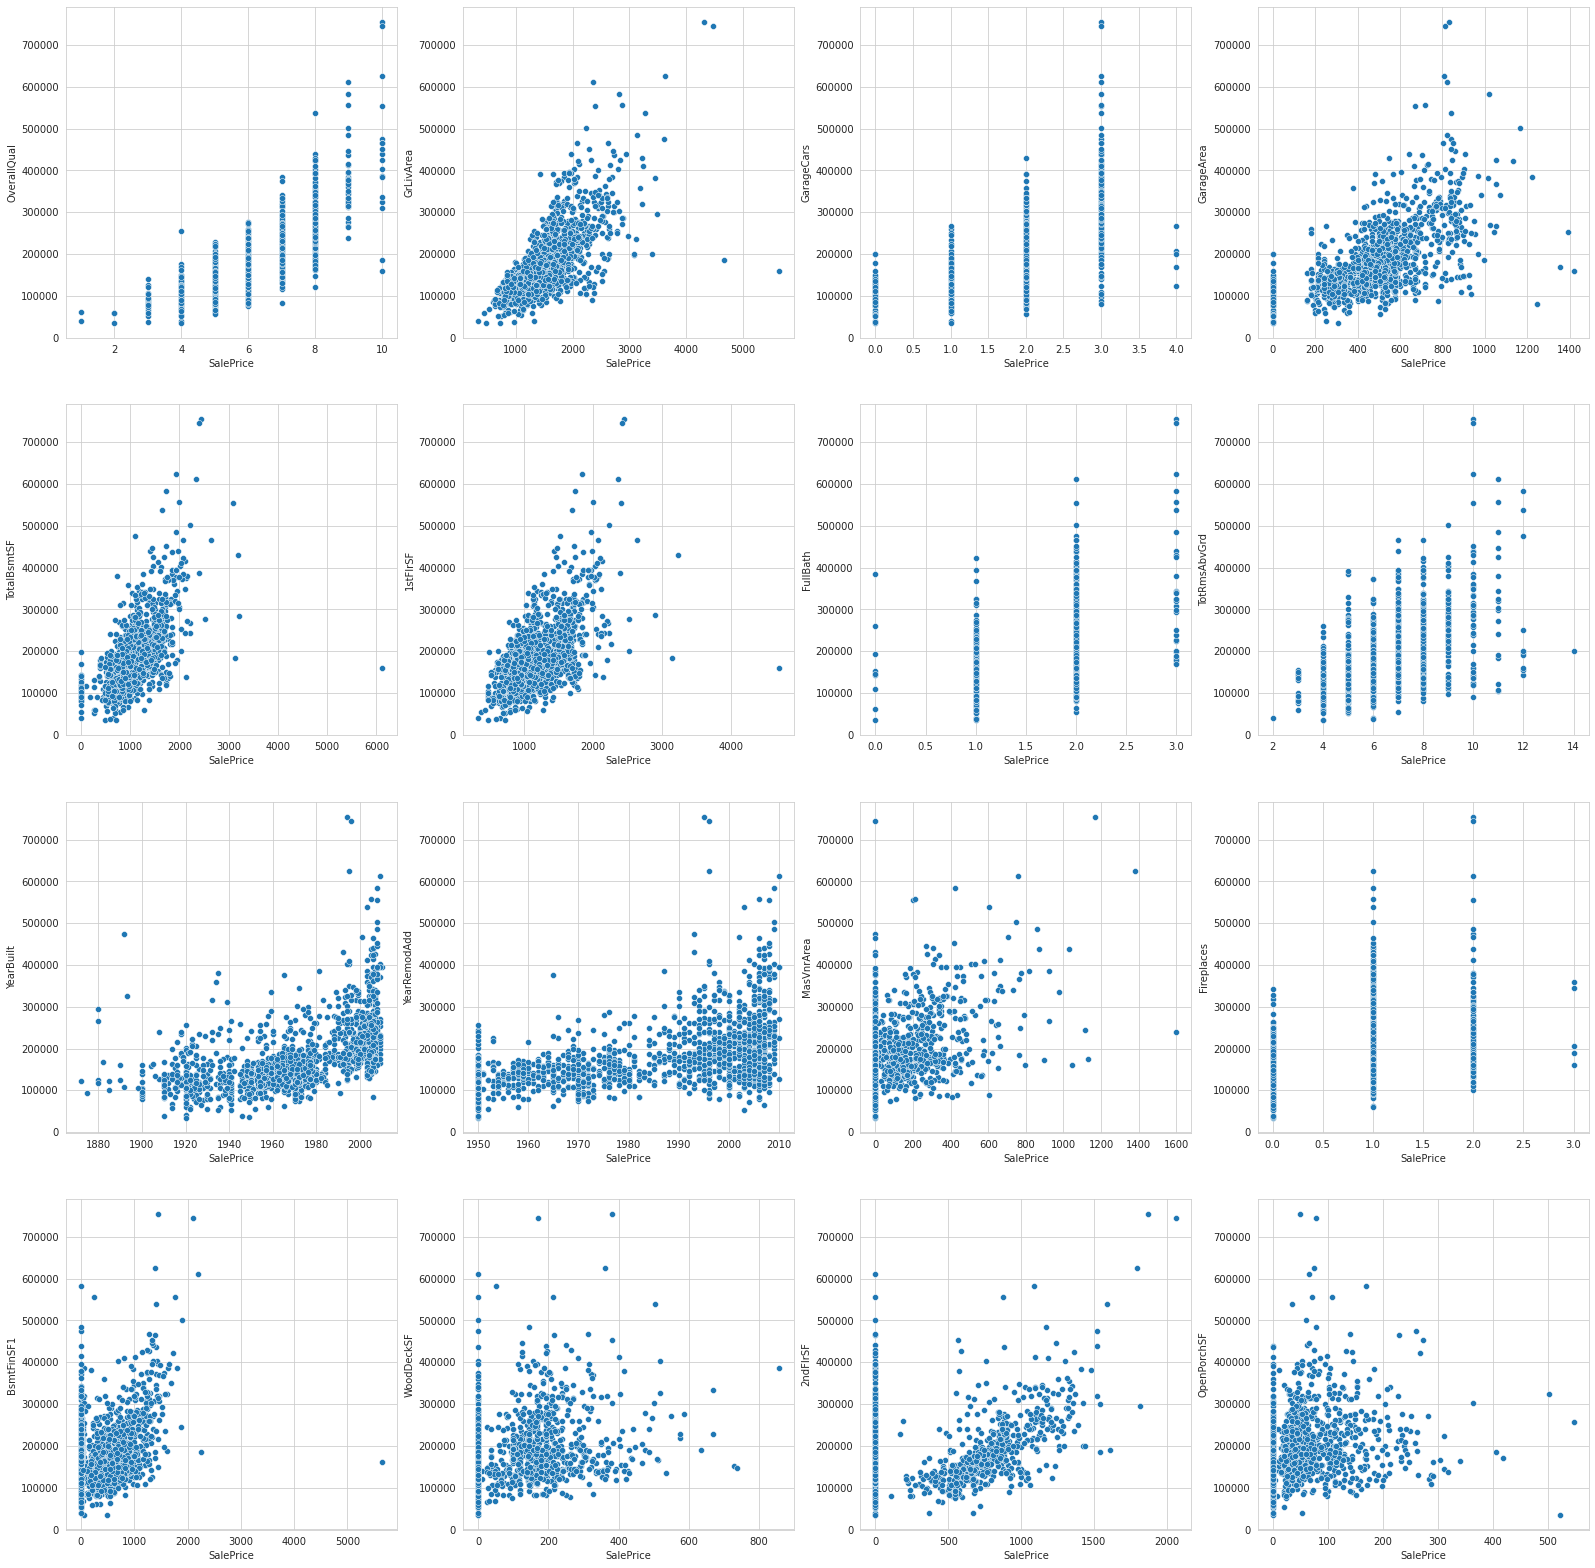

In [10]:
fig, axs = plt.subplots(4, 4, figsize=(18, 18))
plt.subplots_adjust(right=1.3, top=1.3)
axs = axs.flatten()
for i, col in enumerate(list(df_train_corr.index[:16])):
    sns.scatterplot(y='SalePrice', x=col, ax=axs[i], data=df_train)
    axs[i].set_xlabel('SalePrice')
    axs[i].set_ylabel(col)
plt.show()

OverallQual is a categorical feature. Therefore, the box plot should be suitable in this case to clearly show the high correlation characteristic between Overall quality ("OverallQual") of the house with the its price ("SalePrice").

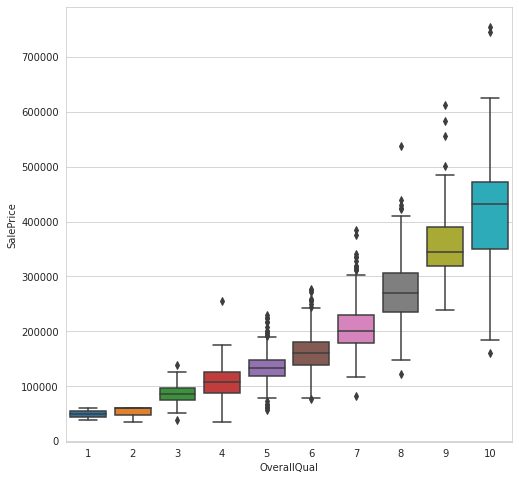

In [11]:
# Corr of "OverallQual": 0.7909
fig = plt.figure(figsize=(8, 8))
sns.boxplot(df_train['OverallQual'], df_train['SalePrice'])
plt.show()

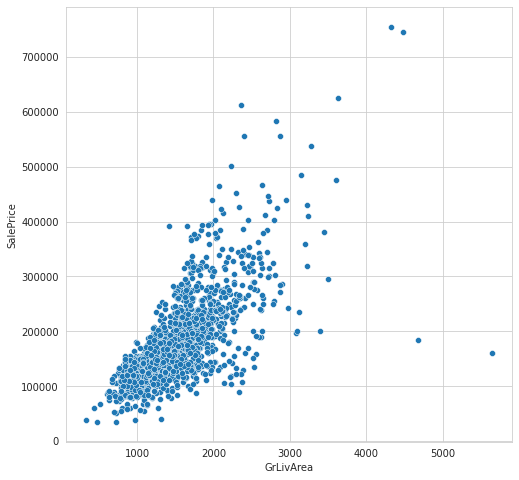

In [12]:
# Corr of "GrLivArea": 0.708
fig = plt.figure(figsize=(8, 8))
sns.scatterplot(df_train['GrLivArea'], df_train['SalePrice'])
plt.show()

<a name='1.3'></a>
## 1.3 Categorical features
- There are totally 38 categorical features in the dataset
- Be careful that there are some categorical features in training dataset containing some values which do not exist in  the same features of testing dataset (E.g "Condition2" feature). We'll detect them and fix them later

In [13]:
df_train_cate = df_train.select_dtypes(include=['object', 'category'])
df_train_cate.head()

,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
0,1Fam,TA,No,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
1,1Fam,TA,Gd,ALQ,Unf,Gd,Y,Feedr,Norm,SBrkr,...,RL,None,Veenker,Y,CompShg,Gable,Normal,WD,Pave,AllPub
2,1Fam,TA,Mn,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub
3,1Fam,Gd,No,ALQ,Unf,TA,Y,Norm,Norm,SBrkr,...,RL,None,Crawfor,Y,CompShg,Gable,Abnorml,WD,Pave,AllPub
4,1Fam,TA,Av,GLQ,Unf,Gd,Y,Norm,Norm,SBrkr,...,RL,BrkFace,NoRidge,Y,CompShg,Gable,Normal,WD,Pave,AllPub


- Now we'll visualize the relationship between categorical features and target feature (SalePrice) using violin plot
- Violin plot is effective to categorical features, it shows some important statistic terms so that we can compare between each other

<img src="https://miro.medium.com/max/650/1*TTMOaNG1o4PgQd-e8LurMg.png" style="width:400px;height:400px;">

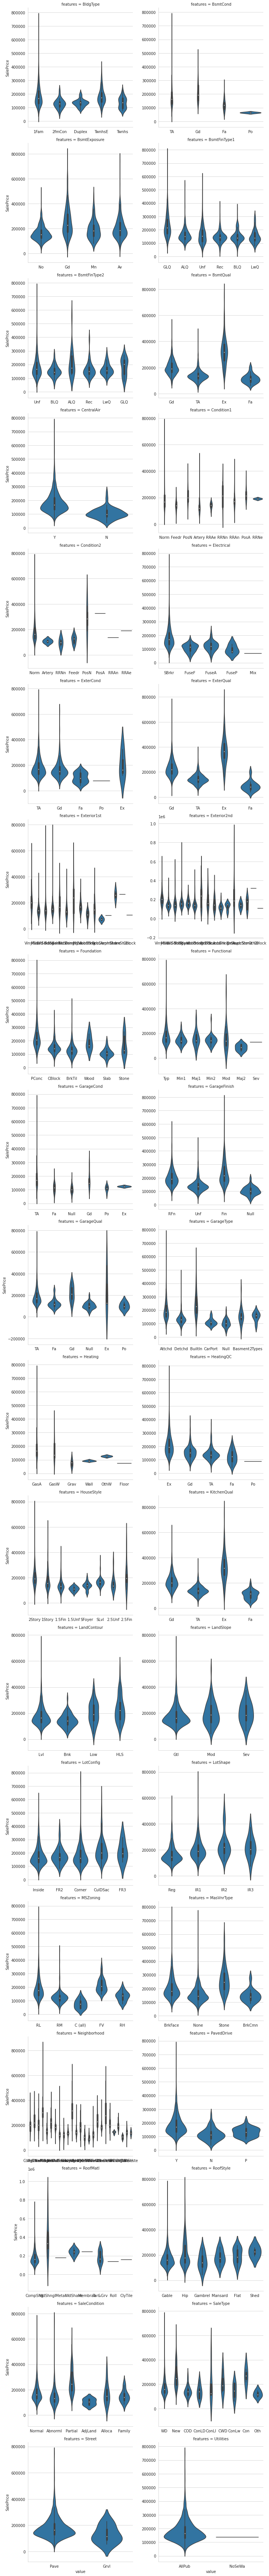

In [14]:
data = pd.melt(pd.concat([df_train_cate, y_train], axis=1),
               id_vars=['SalePrice'], value_vars=df_train_cate.columns, var_name='features')
g = sns.FacetGrid(data, col='features', col_wrap=2, sharex=False, sharey=False, size=5)
g.map(sns.violinplot, 'value', 'SalePrice')

<a name='1.4'></a>
## 1.4 Target column distribution
- Target feature is a heavy-tailed distribution. It'd be problematic to input the small-range features to predict the large-range feature (SalePrice). Therefore, "Box-cox transformation" technique to transform target feature to normal distribution might be appropriate in this occasion
- There're also some large-scale input features & we'll normalize them later 👍👍

In [15]:
# There're some features having the mean smaller than 1 -> Problematic :<
df_train.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,346.992466,3.409589,2.866438,443.639726,46.549315,0.425342,0.057534,567.240411,21.954110,...,6.099315,2.758904,15.060959,6.517808,1057.429452,94.244521,1971.267808,1984.865753,2007.815753,180921.195890
std,386.587738,436.528436,29.317331,0.815778,456.098091,161.319273,0.518911,0.238753,441.866955,61.119149,...,1.382997,40.177307,55.757415,1.625393,438.705324,125.338794,30.202904,20.645407,1.328095,79442.502883
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000,34900.000000
25%,882.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,223.000000,0.000000,...,5.000000,0.000000,0.000000,5.000000,795.750000,0.000000,1954.000000,1967.000000,2007.000000,129975.000000
50%,1087.000000,0.000000,0.000000,3.000000,383.500000,0.000000,0.000000,0.000000,477.500000,0.000000,...,6.000000,0.000000,0.000000,6.000000,991.500000,0.000000,1973.000000,1994.000000,2008.000000,163000.000000
75%,1391.250000,728.000000,0.000000,3.000000,712.250000,0.000000,1.000000,0.000000,808.000000,0.000000,...,7.000000,0.000000,0.000000,7.000000,1298.250000,168.000000,2000.000000,2004.000000,2009.000000,214000.000000
max,4692.000000,2065.000000,508.000000,8.000000,5644.000000,1474.000000,3.000000,2.000000,2336.000000,552.000000,...,10.000000,738.000000,480.000000,14.000000,6110.000000,857.000000,2010.000000,2010.000000,2010.000000,755000.000000


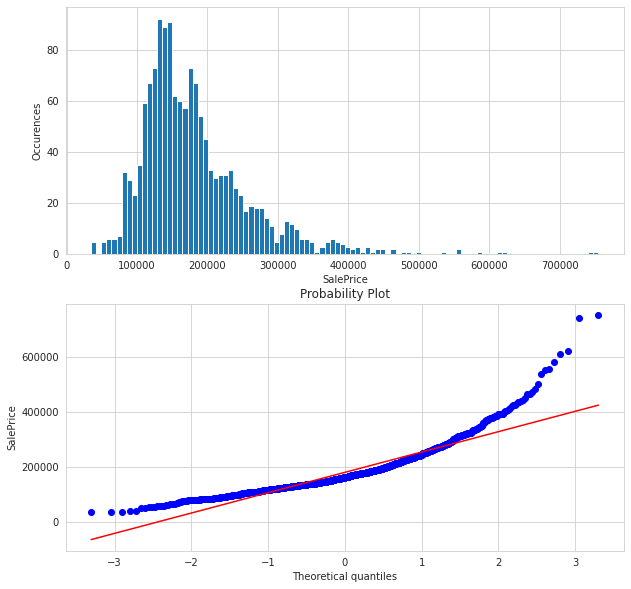

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
y_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Occurences')
ax1.set_xlabel('SalePrice')

stats.probplot(y_train, dist=stats.norm, plot=ax2)
ax2.set_ylabel('SalePrice')
plt.show()

- Target feature is a heavy-tailed distribution --> So Box-Cox transformation should be useful to bring the target from heavy-tailed to normal distribution

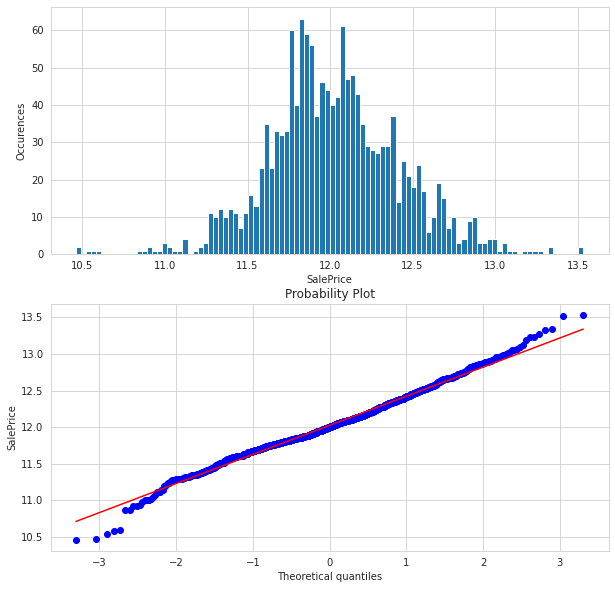

In [17]:
# Using Box-Cot transformation on target feature
org_y_train = y_train
y_train = pd.Series(stats.boxcox(y_train, lmbda=0), name='SalePrice')

# Visualize target after box-cox transformation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
y_train.hist(bins=100, ax=ax1)
ax1.set_ylabel('Occurences')
ax1.set_xlabel('SalePrice')

stats.probplot(y_train, dist=stats.norm, plot=ax2)
ax2.set_ylabel('SalePrice')
plt.show()

**Skewness**
- Is the degree of distortion from the symmetrical normal curve --> Skewness of normal distribution is "0"
- **Positive skewness** means the tail on the right side of the distribution is longer and fatter
- **Negative skewness** means the tail on the left side of the ditribution is longer and fatter

**Kurtosis**
- In probability theory and statistics, **Kurtosis** is the measure of extreme values (outliers) presented in the distribution

In [18]:
# Compute Skewness & Kurtosis
print(f'Skewness before transformation: {stats.skew(org_y_train)}')
print(f'Kurtosis before transformation: {stats.kurtosis(org_y_train)}\n')

print(f'Skewness after transformation: {stats.skew(y_train)}')
print(f'Kurtosis after transformation: {stats.kurtosis(y_train)}')

Skewness before transformation: 1.880940746034036
Kurtosis before transformation: 6.509812011089439

Skewness after transformation: 0.1212103673013655
Kurtosis after transformation: 0.8026555069117713


<a name='2'></a>
# 2. Feature engineering

<a name='2.1'></a>
## 2.1 Binning continuous features
- Using "Bin" technique to all features representing "year" value (Ex: 2000, 1999,...)
- And after that encoding them into continuous features

In [19]:
# Using binned technique for "YearBuilt", "YearRemodAdd" & "YrSold"
df_all['YearBuilt'] = pd.qcut(df_all['YearBuilt'], 10, duplicates='drop')
df_all['YearRemodAdd'] = pd.qcut(df_all['YearRemodAdd'], 10, duplicates='drop')
df_all['YrSold'] = pd.qcut(df_all['YrSold'], 10, duplicates='drop')

In [20]:
# Encode categorical features to numeric feature
for cate_col in ['YearBuilt', 'YearRemodAdd', 'YrSold']:
    df_all[cate_col] = preprocessing.LabelEncoder().fit_transform(df_all[cate_col].values)

Next we'll visualize the year features after applying the binning technique

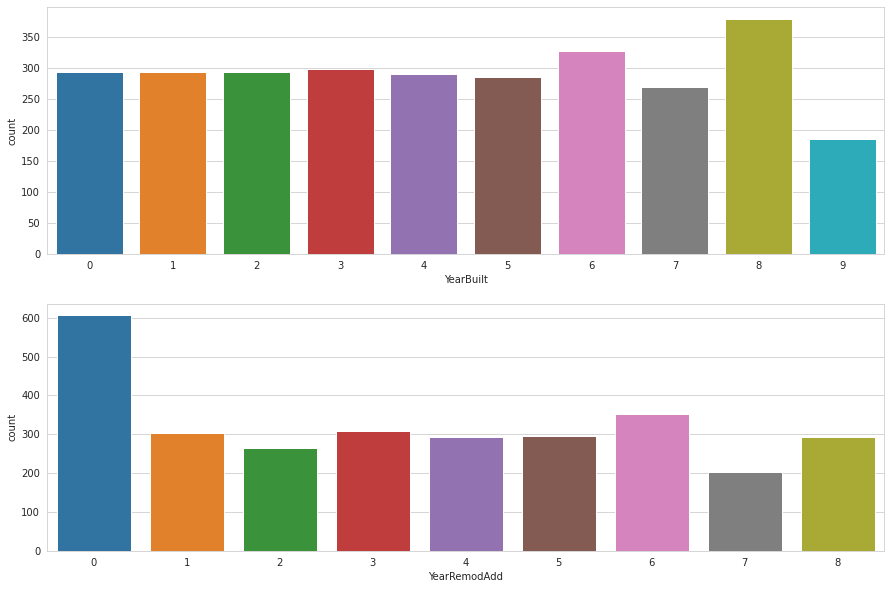

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
sns.countplot(df_all['YearBuilt'], ax=axs[0])
sns.countplot(df_all['YearRemodAdd'], ax=axs[1])
plt.show()

And then transform some numeric features that are actually the categorical feature

In [22]:
# Transform numeric features that are really the categorical features
df_all['MSSubClass'] = df_all['MSSubClass'].astype(str)
df_all['OverallCond'] = df_all['OverallCond'].astype(str)
df_all['MoSold'] = df_all['MoSold'].astype(str)

<a name='2.2'></a>
## 2.2 Construct new useful features
- There are some features that we can concatunate them together to get more useful features
- After constructing new features, all the recipe features might be removed b.c these features and the new one both represent the same type of infomation. Therefore, they would not be more effective to be together than to be alone

In [23]:
# Generating new features
# Total square foot
df_all['TotalSF'] = df_all['BsmtFinSF1'] + df_all['BsmtFinSF2'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

# Total number of bathroom
df_all['TotalBath'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) +
                               df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))
df_all['TotalBsmtbath'] = df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath'])

# Total square feet of porch in a house
df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] +
                            df_all['EnclosedPorch'] + df_all['ScreenPorch'] + df_all['WoodDeckSF'])

# Check the exist of each infrastructure (Ex: basement, bath,...) in a house
df_all['IsRemodel'] = df_all[['YearBuilt', 'YearRemodAdd']].apply(lambda x: 1 if x[0] != x[1] else 0, axis=1)
df_all['HasPool'] = df_all['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['Has2ndFloor'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasGarage'] = df_all['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasBsmt'] = df_all['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_all['HasFireplace'] = df_all['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [24]:
# Drop all the recipe features
remove_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'FullBath', 'HalfBath', 'BsmtFullBath',
              'BsmtHalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']
df_all.drop(remove_cols, axis=1, inplace=True)

In [25]:
# List of categorical features
cate_features = list(df_all.select_dtypes(include=['object', 'category']).columns)

# List of numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_features = list(df_all.select_dtypes(include=numeric_dtypes).columns)

In [26]:
# Update training and testing dataset
df_train, df_test = divide_df(df_all)

<a name='2.3'></a>
## 2.3 Feature selection

<a name='2.3.1'></a>
### 2.3.1 Select categorical features
- Using **forward feature selection** to select the categorical features
- **Forward selection** is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model until the technique finishs choosing k features as we set
- RandomForest Regression can be used as a model to filter the features
- There are totally 38 numerical features, I'll use forward feature selection technique to select the most 30 correlated categorical features with the target
- Because this forward selection technique trains on categorical data to filter features. Therefore, I need to encode the categorical features using "label encoding" technique first, but only for this step not for actual training

**(NOTE)** Because of the iterative training process, so I commented the training code and print out the result below for avoiding time processing. If you're curious, you can uncomment it and try by yourself 

In [27]:
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [28]:
def forward_feature_selection(df_train, cate_features):
    '''Activate the "forward feature selection" technique to select the most appropriate features
    Arg:
        cate_features: list of string names of all categorical features in dataset
    Return:
        SFS object
        '''
    # df prepared for inputing into the technique
    pre_ffs = pd.DataFrame(columns=cate_features)

    # Encode categorical features to numeric feature for utilize "forward selection feature"
    for cate_col in cate_features:
        pre_ffs[cate_col] = preprocessing.LabelEncoder().fit_transform(df_train[cate_col].values)
        
    # Step forward feature selection
    sfs1 = SFS(RandomForestRegressor(),
               k_features=2,
               forward=True,
               floating=False,
               verbose=2,
               scoring='r2',
               cv=3)
    
    sfs1 = sfs1.fit(np.array(pre_ffs[cate_features]), np.array(y_train))
    return sfs1

# (UNCOMMENT HERE TO TRY)
# Choose categorical features using SFS technique
# sfs1 = forward_feature_selection(df_train, cate_features)

# Print out the chosen categorical feature
# cate_features = list(df_all[cate_features].columns[list(sfs1.k_feature_idx_)])
# cate_features

In [29]:
cate_features =  ['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
 'ExterCond', 'ExterQual', 'Exterior2nd', 'Functional', 'GarageCond', 'GarageType', 'Heating', 'HouseStyle', 'KitchenQual',
 'LandContour', 'LandSlope', 'LotShape', 'MSSubClass', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle',
 'SaleCondition', 'SaleType', 'Street', 'Utilities']

<a name='2.3.2'></a>
### 2.3.2 Mismatched value between train & test set in categorical features
- In some case, some columns in train dataset contained values which do not exist in testing dataset, we called them **missmatched data** between train and test
- This would be an serious problem if we plan to perform one-hot encoding for categorical features in the future because of the different number of features between train and test data
- Below are an example of missmatched data in "Electrical" feature. The value "mix" exist in training set but not in testing set

In [30]:
# "Electrical" is an example of mismatched feature values
print('In training dataset\n', df_train['Electrical'].value_counts(), '\n')
print('In testing dataset\n', df_test['Electrical'].value_counts())

In training dataset
 SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64 

In testing dataset
 SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


In [31]:
cate_mismatch = list()

# Determine features contained mismatched values
for cate_col in cate_features:
    train_cate = df_train[cate_col].value_counts().index
    test_cate = df_test[cate_col].value_counts().index
    check_len = len(np.setdiff1d(train_cate, test_cate)) + len(np.setdiff1d(test_cate, train_cate))
    if check_len != 0:
        cate_mismatch.append(cate_col)
        
print('List of mismatched value features: \n', cate_mismatch)

List of mismatched value features: 
 ['Condition2', 'Electrical', 'Exterior2nd', 'Heating', 'HouseStyle', 'MSSubClass', 'RoofMatl', 'Utilities']


- For dealing with mismatched values, I'll replace them by the values having the highest frequency in each feature. 
- With some features having high number of different values, I think removing them might be a good choice

In [32]:
# "Electrical" features
df_train['Electrical'].loc[df_train['Electrical']=='Mix'] = 'SBrkr'

# "Exterior2nd" features
df_train['Exterior2nd'].loc[df_train['Exterior2nd']=='Other'] = 'VinylSd'

# "Heating" features
df_train['Heating'].loc[df_train['Heating']=='OthW'] = 'GasA'
df_train['Heating'].loc[df_train['Heating']=='Floor'] = 'GasA'

# "HouseStyle" features
df_train['HouseStyle'].loc[df_train['HouseStyle']=='2.5Fin'] = '1.5Fin'

# "MSSubClass" features
df_test['MSSubClass'].loc[df_test['MSSubClass']=='150'] = '160'

# "Condition2" feature
temp = [True if ((val=='RRNn') | (val=='RRAn') | (val=='RRAe')) else False
        for val in df_train['Condition2']]
df_train['Condition2'].loc[temp] = 'Norm'

# "Utilities" is a constant-value feature --> Delete it
# "RoofMatl" has high number of different values --> Delete it
cate_drop = ['Utilities', 'RoofMatl']
df_train.drop(cate_drop, axis=1, inplace=True)
df_test.drop(cate_drop, axis=1, inplace=True)

# Update the cate_features list also
cate_features = [col for col in cate_features if col not in cate_drop]

In [33]:
# Check "Condition2" feature
print('In training dataset\n', df_train['Electrical'].value_counts(), '\n')
print('In testing dataset\n', df_test['Electrical'].value_counts())

In training dataset
 SBrkr    1336
FuseA      94
FuseF      27
FuseP       3
Name: Electrical, dtype: int64 

In testing dataset
 SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


Great!! All the mismatched values are fixed. Now let's move to selecting the continuous features

<a name='2.3.3'></a>
### 2.3.3 Select contunious features
- The Pearson correlation coeficient is a statistical measure of the strength of a linear association between 2 continuous features. This technique is suitable for linear correlation, or rank-based methods for a non linear correlation
- Therefore, Pearson could be a compeling choice for choosing the features having high correlation to the SalePrice target

Reference link: [here](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)

In [34]:
# Find feature correlation with target using pearson's coeficient
pearson = dict()
for col in num_features:
    pear_val = stats.pearsonr(np.array(df_train[col]), np.array(y_train))[0]
    pearson[col] = pear_val
    
pearson = pd.Series(pearson).abs().sort_values(ascending=False)
# Choose only feature having correlation larger than 0.2
num_features = list(pearson.loc[pearson > 0.2].index)
num_features

['OverallQual',
 'GrLivArea',
 'TotalSF',
 'GarageCars',
 'TotalBath',
 'GarageArea',
 'YearBuilt',
 'TotalBsmtSF',
 '1stFlrSF',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'HasFireplace',
 'Fireplaces',
 'MasVnrArea',
 'TotalPorchSF',
 'HasGarage',
 '2ndFlrSF',
 'LotArea',
 'TotalBsmtbath',
 'BsmtUnfSF',
 'BedroomAbvGr']

<AxesSubplot:>

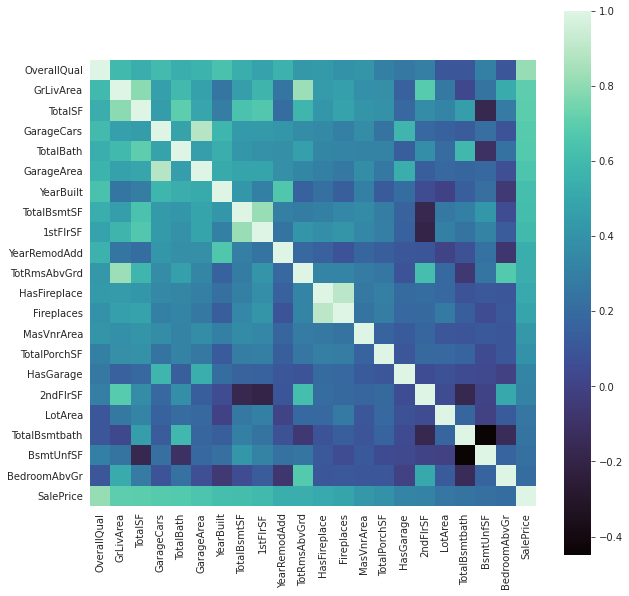

In [35]:
chosen_cols = num_features + cate_features

# Visualizing the correlation table
fig = plt.figure(figsize=(10, 10))
sns.heatmap(pd.concat([df_train[chosen_cols], y_train], axis=1).corr(), square=True,
            cmap='mako', annot_kws={'size': 14})

In [36]:
df_train = df_train[chosen_cols]
df_test = df_test[chosen_cols]
df_all = concat_df(df_train, df_test)

<a name='2.4'></a>
## 2.4 Features transformation

<a name='2.4.1'></a>
### 2.4.1 Highly skewed numeric features
- Highly skewed numeric features are the heavy-tail features like our target features
- We decide whether a feature is skewness or not based on the value of "skewness" statistics measurement
- All skewed features will be normalize by Box-cox normalization technique

In [37]:
# Normalize skewness feature using Log function
skew_features = df_all[num_features].apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skew_features = skew_features[abs(skew_features) > 0.75]
print(skew_features)           

# Apply Box cox for skewness > 0.75
for feat in skew_features.index:
    df_all[feat] = np.log1p(df_all[feat])

LotArea         12.822431
MasVnrArea       2.613592
TotalSF          1.835745
1stFlrSF         1.469604
TotalPorchSF     1.376649
GrLivArea        1.269358
TotalBsmtSF      1.162616
BsmtUnfSF        0.919703
2ndFlrSF         0.861675
TotRmsAbvGrd     0.758367
HasGarage       -3.955907
dtype: float64


In [38]:
df_train, df_test = divide_df(df_all)

<a name='2.4.2'></a>
### 2.4.2 One-hot encoding categorical features
Now after finishing preprocessing all the categorical features, we should encode them to numeric features to be successfully inputted into the model by "one-hot encoding" technique. 

In [39]:
print(df_train.shape, df_test.shape)

(1460, 48) (1459, 48)


In [40]:
# Transform categorical feature to dummies features
encoded_features = list()

for df in [df_train, df_test]:
    for feature in cate_features:
        # Change to array after encoding b.c want to add columns when change back to df
        encoded_feat = preprocessing.OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        # "n": Number of unique value in each feature
        n = df[feature].nunique()
        # "feature_uniqueVal" are the col's names in df after One-hot encoding
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
        
df_train = pd.concat([df_train, *encoded_features[:len(cate_features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(cate_features):]], axis=1)

After encoding all the categorical features, we need to remove the original ones to prevent training the same type of information. Because the orginal categorical features and their one-hot encoding version represent the same infomation

In [41]:
# Drop original category features
df_train.drop(cate_features, axis=1, inplace=True)
df_test.drop(cate_features, axis=1, inplace=True)

df_all = concat_df(df_train, df_test)

In [42]:
print(df_train.shape, df_test.shape)

(1460, 196) (1459, 196)


Now the number of features in training and testing dataset are the same & all the preprocessing steps are finished. The data is ready for training!!

In [43]:
df_train.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtUnfSF,Fireplaces,GarageArea,GarageCars,GrLivArea,HasFireplace,HasGarage,...,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleType_9,Street_1,Street_2
0,6.753438,6.751101,3,5.017280,0,548.0,2.0,7.444833,0,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,7.141245,0.000000,3,5.652489,1,460.0,2.0,7.141245,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,6.825460,6.765039,3,6.075346,1,608.0,2.0,7.488294,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,6.869014,6.629363,3,6.293419,1,642.0,3.0,7.448916,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,7.044033,6.960348,4,6.196444,1,836.0,3.0,7.695758,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


<a name='3'></a>
# 3. Modeling

In [44]:
from sklearn.model_selection import KFold # for repeated K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation
from sklearn.model_selection import cross_val_predict # prediction
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import time
SEED = 42

In [45]:
# Repeated K-fold cross validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Return root mean square error of model prediction (Used for test prediction)
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Return root mean square error applied cross validation (Used for training prediction)
def evaluate_model_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

<a name='3.1'></a>
## 3.1 Base models
We'll plan to construct these below based model
- **Ridge** is regression model applying l2 regularization technique. ([Link here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html))
- **Lasso** stands for Least Absolute Shrinkage and Selection Operator that is a linear regression model applied l1 regularization technique ([Link here](https://www.statisticshowto.com/lasso-regression/))
- **elasticnet** is a penalized linear regression model that includes both the L1 and L2 penalties during training ([Link here](https://machinelearningmastery.com/elastic-net-regression-in-python/))
- **svr** stands for Support Vector Regression is a type of "SVM" model using for regression problem ([Link here](https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2))
- **gbr** is gradient boosting model for regression problem ([Link here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html))
- **lgbm** is a fast, distributed, high-performance gradient boosting framework that uses a tree-based learning algorithm ([Link here](https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/))
- **xgboost** is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework ([Link here](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d#:~:text=What%20is%20XGBoost%3F,all%20other%20algorithms%20or%20frameworks.))

In [46]:
def construct_models():
    # Initialize parameters for models
    alphas_ridge = [0.005, 0.01, 0.1, 1, 5, 10, 15]
    alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
    e_alphas_elas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
    e_l1ratio_elas = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
    
    # Constructing the models
    models = dict()
    
    models['ridge'] = RidgeCV(alphas=alphas_ridge, cv=kfolds)
    models['lasso'] = LassoCV(alphas=alphas_lasso, random_state=SEED, cv=kfolds)
    models['elasticnet'] = ElasticNetCV(alphas=e_alphas_elas, cv=kfolds, l1_ratio=e_l1ratio_elas)
    models['svr'] = SVR(C = 20, epsilon = 0.008, gamma =0.0003)
    models['gbr'] = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, 
                                              max_depth=4, max_features='sqrt',
                                              min_samples_leaf=15, min_samples_split=10, 
                                              loss='huber',random_state =SEED) 
    models['lgbm'] = LGBMRegressor(objective='regression', num_leaves=4,
                                   learning_rate=0.01, n_estimators=5000,
                                   max_bin=200, bagging_fraction=0.75,
                                   bagging_freq=5, bagging_seed=7,
                                   feature_fraction=0.2,
                                   feature_fraction_seed=7, verbose=-1,
                                  colsample_bytree=None, subsample=None, subsample_freq=None)
    models['xgboost'] = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7, verbosity = 0,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=SEED, reg_alpha=0.00006)
    return models

# Construct the set of model
models = construct_models()

After design and construct the based model, we need to fit the training data to the model and compute the root mean square error (rmse) result to validate models after the training
- **Note that:** numpy array is recommended as an input to the training model instead of Dataframe. Because numpy has a hugh benefit relating to the time consuming than pandas. Link for more infomation [Here](https://towardsdatascience.com/speed-testing-pandas-vs-numpy-ffbf80070ee7)

In [47]:
for name, model in models.items():
    # Start counting time
    start = time.perf_counter()
    
    model = model.fit(np.array(df_train), np.array(y_train))
    rmse_result = rmse(y_train, model.predict(np.array(df_train)))
    print(f'{name}\'s rmse after training: {rmse_result}')
    
    # Compute time for executing each algo
    run = time.perf_counter() - start
    print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

ridge's rmse after training: 0.11872304460054574
Computational runtime of this algo: 1.12 seconds

lasso's rmse after training: 0.12077390109400547
Computational runtime of this algo: 0.53 seconds

elasticnet's rmse after training: 0.12038810145588948
Computational runtime of this algo: 2.8 seconds

svr's rmse after training: 0.09852459645780219
Computational runtime of this algo: 2.12 seconds

gbr's rmse after training: 0.05981278748723607
Computational runtime of this algo: 11.08 seconds

lgbm's rmse after training: 0.08969168841978778
Computational runtime of this algo: 2.71 seconds

xgboost's rmse after training: 0.05894860617444021
Computational runtime of this algo: 11.48 seconds



- "Overfitting" problem happens when the model overlearns the detail of training dataset so that it'll negatively impact the performance of model on the testing dataset. In short, when the performance on training dataset is much more higher than performance on testing dataset
- Computing rmse applying cross validation technique is effective to prevent the "Overfitting" problem

In [48]:
cv_rmse_result = dict()
cv_rmse_mean = dict()
cv_rmse_std = dict()

for name, model in models.items():
    # Start counting time
    start = time.perf_counter()
    
    cv_rmse_result[name] = evaluate_model_cv(model, np.array(df_train), np.array(y_train))
    cv_rmse_mean[name] = cv_rmse_result[name].mean()
    cv_rmse_std[name] = cv_rmse_result[name].std()
    print(f'Finish {name}\'s model')
    
    # Compute time for executing each algo
    run = time.perf_counter() - start
    print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

Finish ridge's model
Computational runtime of this algo: 9.42 seconds

Finish lasso's model
Computational runtime of this algo: 5.52 seconds

Finish elasticnet's model
Computational runtime of this algo: 27.81 seconds

Finish svr's model
Computational runtime of this algo: 12.63 seconds

Finish gbr's model
Computational runtime of this algo: 106.05 seconds

Finish lgbm's model
Computational runtime of this algo: 26.11 seconds

Finish xgboost's model
Computational runtime of this algo: 98.82 seconds



In [49]:
ML_cv = pd.DataFrame({'cv_rsme_mean' : cv_rmse_mean, 'cv_rmse_std' : cv_rmse_std})
ML_cv

,cv_rsme_mean,cv_rmse_std
ridge,0.131218,0.020660
lasso,0.130538,0.022071
elasticnet,0.130492,0.021949
svr,0.150743,0.020673
gbr,0.128461,0.020674
lgbm,0.127312,0.016463
xgboost,0.125809,0.018500


<a name='3.2'></a>
## 3.2 Stacking model
- In statistics and machine learning, ensemble methods use multiple learning algorithms to obtain better predictive performance than the learning algorithm alone. **Stacking model** is an ensemble one
- It uses a meta-learning algorithm to learn how to best combine the predictions from two or more base machine learning algorithms.

Reference link: [Stacking model](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)

In [50]:
# Type 1 stacking model
stack_model = StackingCVRegressor(regressors=(models['ridge'], models['lasso'], models['xgboost'],
                                              models['elasticnet'], models['gbr'], models['lgbm']),
                                  meta_regressor=models['xgboost'], use_features_in_secondary=True)

In [51]:
# Time performance counter
start = time.perf_counter()

stack_model = stack_model.fit(np.array(df_train), np.array(y_train))
print('Finish training')

# Compute rmse with cross-validation technique
# rmse_stack_cv = evaluate_model_cv(stack_model, np.array(df_train), y_train)
# print(f'stack_model\'s rmse (using cv) after training: {rmse_stack_cv.mean()}')

# Compute rmse without cross-validation technique
rmse_stack = rmse(y_train, stack_model.predict(np.array(df_train)))
print(f'stack_model\'s rmse (using cv) after training: {rmse_stack}')

# Compute time for executing each algo
run = time.perf_counter() - start
print(f'Computational runtime of this algo: {round(run, 2)} seconds\n')

Finish training
stack_model's rmse (using cv) after training: 0.0556176787629728
Computational runtime of this algo: 165.86 seconds



<a name='3.3'></a>
## 3.3 Blending model
- **Blending** is an ensemble machine learning technique that uses a machine learning model to learn how to best combine the predictions from multiple contributing ensemble member models
- For more understanding, the link [Blending model](https://mlwave.com/kaggle-ensembling-guide/) might be useful!

In [52]:
def blend_models_predict(X):
    return ((0.05 * models['ridge'].predict(np.array(X))) + \
            (0.05 * models['lasso'].predict(np.array(X))) + \
            (0.05 * models['elasticnet'].predict(np.array(X))) + \
            (0.15 * models['gbr'].predict(np.array(X))) + \
            (0.15 * models['lgbm'].predict(np.array(X))) + \
            (0.25 * models['xgboost'].predict(np.array(X))) + \
            (0.3 * stack_model.predict(np.array(X))))

In [53]:
print('RMSLE score on train data:')
print(rmse(y_train, blend_models_predict(np.array(df_train))))

RMSLE score on train data:
0.06571547564683625


<a name='4'></a>
# 4 Submision

In [54]:
# Get the id feature from testing dataset
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
test_id = test['Id']

In [55]:
# Submission set
submit = pd.concat((test_id, pd.Series(np.exp(blend_models_predict(df_test)), 
                                       name='SalePrice')), axis=1)
submit.to_csv('Submission.csv', index=False)